In [1]:
# Makes it easier to debug
%load_ext autoreload
#%load_ext line_profiler
%autoreload 2

In [2]:
import pylab as plt
import numpy as np
import skimage.transform
import skimage.restoration
from tqdm import tqdm
import skimage.filters
import torch
import torch.nn as nn
import typing as tp
from pyrofit.utils import pad_dims
from torch.nn.functional import grid_sample
from pyro import distributions as dist
from pyrofit.lensing.utils import get_meshgrid
from pyrofit.lensing.lenses import SPLELens
from pyrofit.lensing.sources import SersicSource, AnalyticSource
from pyrofit.utils.torchutils import _mid_many, unravel_index
from pyrofit.utils import kNN
from fft_conv_pytorch import fft_conv, FFTConv2d
import swyft
from dataclasses import dataclass
from swyft.alpha.components import RatioEstimatorGaussian1d, MeanStd, SimpleDataset
import pytorch_lightning as pl
from torch.nn import functional as F

## Todo list

- [ ] Dictionary-valued parameters
- [ ] No enforced network structure

## Basic idea

1) We learn $p(L|I)$ based on joined samples $L, I \sim p(L, I)$ vs marginal samples $L, I \sim p(L) p(I)$.  Here, we identify $z = L$ and $x = I$.
2) We learn $p(S|I, L)$, based on the identification of $x = (I, L)$ and $z=S$.

In [3]:
torch.cuda.set_device(0)
torch.set_default_tensor_type(torch.cuda.FloatTensor)
DEVICE='cuda'

In [4]:
NPIX = 50
CHANNELS = [0.5, 1, 2, 4, 8, 16, 32]
SIGMA = 0.02
KNN = 3

## General helper functions - should be part of swyft

In [5]:
def get_1d_rect_bounds(samples, th = 1e-6):
    bounds = {}
    for k, v in samples.items():
        w = v[..., 0]
        p = v[..., 1]
        all_max = p.max(dim=0).values
        all_min = p.min(dim=0).values
        constr_min = torch.where(w > np.log(th), p, all_max).min(dim=0).values
        constr_max = torch.where(w > np.log(th), p, all_min).max(dim=0).values
        bound = torch.stack([constr_min, constr_max], dim = -1)
        bounds[k] = bound
    return bounds

In [6]:
def append_randomized(z):
    assert len(z)%2 == 0, "Cannot expand odd batch dimensions."
    n = len(z)//2
    idx = torch.randperm(n)
    z = torch.cat([z, z[n+idx], z[idx]])
    return z

In [7]:
def valmap(m, d):
    return {k: m(v) for k, v in d.items()}

In [8]:
class SwyftModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self._predict_condition_x = {}
        self._predict_condition_z = {}
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30)
        lr_scheduler = {"scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer), "monitor": "val_loss"}
        return dict(optimizer = optimizer, lr_scheduler = lr_scheduler)

    def _log_ratios(self, x, z):
        out = self(x, z)
        log_ratios = torch.cat([val[..., 0].flatten(start_dim = 1) for val in out.values()])
        return log_ratios
    
    def validation_step(self, batch, batch_idx):
        loss = self._calc_loss(batch, batch_idx)
        self.log("val_loss", loss)
        return loss
        
    def _calc_loss(self, batch, batch_idx):
        x, z = batch
        z = valmap(append_randomized, z)
        log_ratios = self._log_ratios(x, z)
        nbatch = len(log_ratios)//2
        y = torch.zeros_like(log_ratios)
        y[:nbatch, ...] = 1
        loss = F.binary_cross_entropy_with_logits(log_ratios, y, reduce = False)
        loss = loss.sum()
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self._calc_loss(batch, batch_idx)
        self.log("train_loss", loss)
        return loss
    
    def _set_predict_conditions(self, condition_x, condition_z):
        self._predict_condition_x = {k: v.unsqueeze(0) for k, v in condition_x.items()}
        self._predict_condition_z = {k: v.unsqueeze(0) for k, v in condition_z.items()}
    
    def predict_step(self, batch, batch_idx):
        x, z = batch
        condition_x = swyft.utils.dict_to_device(self._predict_condition_x, self.device)
        x.update(**condition_x)
        #z.update(**self._predict_condition_z)
        return self(x, z)

In [9]:
def equalize_tensors(a, b):
    n, m = len(a), len(b)
    if n == m:
        return a, b
    elif n == 1:
        shape = list(a.shape)
        shape[0] = m
        return a.expand(*shape), b
    elif m == 1:
        shape = list(b.shape)
        shape[0] = n
        return a, b.expand(*shape)
    elif n < m:
        assert m%n == 0, "Cannot equalize tensors with non-divisible batch sizes."
        shape = [1 for _ in range(a.dim())]
        shape[0] = m//n
        return a.repeat(*shape), b
    else:
        assert n%m == 0, "Cannot equalize tensors with non-divisible batch sizes."
        shape = [1 for _ in range(b.dim())]
        shape[0] = n//m
        return a, b.repeat(*shape)

In [10]:
class SwyftTrainer(pl.Trainer):
    def infer(self, dataloader, condition_x = {}, condition_z = {}):
        self.model._set_predict_conditions(condition_x, condition_z)
        ratio_batches = self.predict(dataloaders = dataloader)
        keys = ratio_batches[0].keys()
        d = {k: torch.cat([r[k] for r in ratio_batches]) for k in keys}
        self.model._set_predict_conditions({}, {})  # Set it back to no conditioning
        return d

In [11]:
class DictStore(dict):
    def __len__(self):
        n = [len(v) for v in self.values()]
        assert all([x == n[0] for x in n]), "Inconsistent lengths in DictStore"
        return n[0]
    
    def _get_ith_entry(self, i):
        return {k: v[i] for k, v in self.items()}
    
    def __getitem__(self, k):
        if isinstance(k, int):
            return self._get_ith_entry(k)
        else:
            return super().__getitem__(k)

In [12]:
# Generate new dictionary

def dictstoremap(model, dictstore):
    N = len(dictstore)
    out = []
    for i in tqdm(range(N)):
        x = model(dictstore[i])
        out.append(x)
    out = torch.utils.data.dataloader.default_collate(out) # using torch internal functionality for this, yay!
    out = {k: v.cpu() for k, v in out.items()}
    return out

In [13]:
# Since we want to learn the src parameters, which are generated inside the generative model, 
# we simply attach the flattened src array to the parameter vectors and hope for the best

class DictDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, x_keys, z_keys, hook = None):
        self._dataset = dataset
        self._x_keys = x_keys
        self._z_keys = z_keys
        self._hook = hook

    def __len__(self):
        return len(self._dataset[list(self._dataset.keys())[0]])
    
    def __getitem__(self, i):
        d = {k: v[i] for k, v in self._dataset.items()}
        if self._hook is not None:
            d = self._hook(d)
        x = {k: d[k] for k in self._x_keys}
        z = {k: d[k] for k in self._z_keys}
        return x, z

## Physics model

In [14]:
class RandomSource:
    def __init__(self, npix =  NPIX, channels = CHANNELS, K = 129):
        self._K = K
        self._channels = channels
        self._npix = npix
        
        self._kernels = self._get_kernels(self._K, self._channels)
        self._conv = self._get_kernel_conv(self._kernels)
        
    @staticmethod
    def _get_kernels(K, channels):
        C = len(channels)
        kernel = np.zeros((C, C, K, K))
        x = np.linspace(-64, 64, K)
        X, Y = np.meshgrid(x, x)
        R = (X**2 + Y**2)**0.5

        for i, s in enumerate(channels):
            kern = np.exp(-0.5*R**2/s**2)
            kern /= (kern**2).sum()**0.5
            kernel[i, i] = kern

        return kernel

    @staticmethod
    def _get_kernel_conv(kernel):
        C = len(kernel)
        K = len(kernel[0][0])
        gaussian_weights = nn.Parameter(torch.tensor(kernel).float().cuda())
        conv = FFTConv2d(in_channels = C, out_channels = C, kernel_size=K, bias=False, padding = int(K/2))
        with torch.no_grad():
            conv.weight = gaussian_weights
        return conv

    def _get_source_image(self, seeds, A=0.5, B = 0.3, C = 0.55, D = 4.):
        scales = A*(np.array(self._channels)/max(self._channels))**B
        seeds = seeds * torch.tensor(scales).cuda().float().unsqueeze(1).unsqueeze(2)
        x = torch.linspace(-1, 1, self._npix).to(seeds.device)
        X, Y = torch.meshgrid([x, x])
        R = (X**2 + Y**2)**0.5
        imgc = self._conv(seeds.unsqueeze(0)).squeeze(0).squeeze(0)
        img = imgc.sum(axis=-3)
        img = torch.exp(img)*(1/(1+(R/C)**D))
        return img

    def __call__(self):
        C = len(self._channels)
        return self._get_source_image(torch.randn(C, self._npix, self._npix).cuda()).detach()

In [15]:
class ArraySource(AnalyticSource):
    def __init__(self, image_array, x: float = 0., y: float = 0., scale: float = 1., peak_intensity: float = 1.,
                 origin: tp.Literal['lower', 'upper'] = 'lower', aspect=None, device=None):
        super().__init__(device=device)

        self.x, self.y = x, y
        self.peak_intensity = peak_intensity

        self.image = self._image(image_array, peak_intensity, device)

        if aspect is None:
            aspect = self.image.shape[-2] / self.image.shape[-1]
        self.semi_scale = torch.tensor([scale, (-1 if origin == 'lower' else 1) * aspect * scale], device=device) / 2

    def _image(self, image_array, peak_intensity=None, device=None) -> torch.Tensor:
        image = torch.tensor(image_array)
        if image.shape[-1] in (1, 3, 4):
            image = torch.movedim(image, -1, -3)
        if peak_intensity is not None:
            image = image.to(torch.get_default_dtype())
            image = image / torch.amax(image, (-2, -1), keepdim=True) * peak_intensity
        self.rollback_dims = image.ndim
        return pad_dims(image, ndim=4)[0].to(device=device, dtype=torch.get_default_dtype())

    def flux(self, X, Y):
        grid = torch.stack((X - self.x, Y - self.y), dim=-1).reshape(-1, *X.shape[-2:], 2) / self.semi_scale

        return grid_sample(
            self.image.expand(grid.shape[0], *self.image.shape[-3:]),
            grid,
            align_corners=True
        ).reshape(*X.shape[:-2], *self.image.shape[-self.rollback_dims:-2], *X.shape[-2:])

In [16]:
def get_kNN_idx(X, Y, Xsrc, Ysrc, k = 1):
        """Return indices into `Xsrc` and `Ysrc` closest to each point in `psrc`."""
        P = torch.stack((X, Y), -1).flatten(-3, -2)
        Psrc = torch.stack((Xsrc, Ysrc), -1).flatten(-3, -2)
        idx = unravel_index(kNN(P, Psrc, k).squeeze(-1), Xsrc.shape[-2:])
        idx = torch.reshape(idx, (NPIX, NPIX, k, 2))
        return idx

In [17]:
def deproject_idx(image, kNN_idx):
        """Return indices into `Xsrc` and `Ysrc` closest to each point in `psrc`."""
        k = kNN_idx.shape[-2]
        B = image.shape[0]
        #print(k, B)
        #print(image.shape)
        #print(kNN_idx.shape)
        # TODO: Need to speed up nested python loops
        src_image = torch.stack([torch.stack([image[b, kNN_idx[b, ..., i,0], kNN_idx[b, ..., i,1]] for i in range(k)]) for b in range(B)])
        return src_image

In [18]:
def image_generator(x, y, phi, q, r_ein, slope, src_image):
    res = 0.0125*8                      # resolution in arcsec
    nx, ny = 50, 50                   # number of pixels
    X, Y = get_meshgrid(res, nx, ny)    # grid

    # Lens
    lens = SPLELens(device=DEVICE)
    lens.XY = X,Y
    # Displacement field
    alphas = lens(x=x, y=y, phi=phi, q=q, r_ein=r_ein, slope=slope)

    # Lensing equation
    X_src = X - alphas[..., 0, :, :]
    Y_src = Y - alphas[..., 1, :, :]

    # Source
    source = ArraySource(src_image, peak_intensity = None, scale = 1)

    # Lensed source
    image = source(X=X_src, Y=Y_src)
    
    return image, [X, Y, X_src, Y_src]

## Problem-specific analysis components

In [19]:
def model(pars):
    torch.cuda.set_device(0)
    torch.set_default_tensor_type(torch.cuda.FloatTensor)    
    x, y, phi, q, r_ein, slope = pars['z_lens']
    slope = 2.0
    src_image = pars['src'].cuda()
    img, coords = image_generator(x, y, phi, q, r_ein, slope, src_image)
    X, Y, Xsrc, Ysrc = coords
    kNN_idx = get_kNN_idx(X/5, -Y/5, Xsrc, Ysrc, k = KNN)  # TODO: Need to sort out strange 1/5 and -1/5 factors
    torch.set_default_tensor_type(torch.FloatTensor)
    return dict(img = img.cpu(), kNN_idx = kNN_idx.cpu(), X = X.cpu(), Y = Y.cpu(), Xsrc = Xsrc.cpu(), Ysrc = Ysrc.cpu())

In [20]:
def noise(d):
    d['img'] = d['img'] + torch.randn_like(d['img'])*SIGMA
    return d

In [21]:
# Draw from source prior
def prior_src(N, bounds = None):
    rnd_src = RandomSource()
    src = torch.stack([rnd_src().cpu() for _ in range(N)])
    return DictStore(src=src)

def prior_lens(N, bounds = None):
    if bounds is not None:
        low = bounds['z_lens'][..., 0]
        high = bounds['z_lens'][..., 1]
    else:
        low =  np.array([-0.2, -0.2, 0, 0.2, 1.0, 1.5])
        high = np.array([0.2, 0.2, 1.5, 0.9, 2.0, 2.5])
    draw = np.array([np.random.uniform(low=low, high=high) for _ in range(N)])
    return DictStore(z_lens = torch.tensor(draw).float())

In [22]:
# https://stackoverflow.com/questions/16463582/memoize-to-disk-python-persistent-memoization
#def persist_to_file():
def persist_to_file(original_func):
        def new_func(*args, file_path = None, **kwargs):
            cache = None
            if file_path is not None:
                try:
                    cache = torch.load(file_path)
                except (FileNotFoundError, ValueError):
                    pass
            if cache is None:
                cache = original_func(*args, **kwargs)
                if file_path is not None:
                    torch.save(cache, file_path)
            return cache
        return new_func
    #return decorator

In [23]:
@persist_to_file
def get_datadict(N, bounds = None):
    prior_dict = DictStore(**prior_src(N), **prior_lens(N))
    sim_dict = dictstoremap(model, prior_dict)
    dict_store = DictStore(**prior_dict, **sim_dict)
    return dict_store

In [24]:
@persist_to_file
def get_fake_data():
    dict_store = get_datadict(10)
    dataset = DictDataset(dict_store, hook = noise, x_keys = ['img'], z_keys=['z_lens', 'src'])
    x0, z0 = dataset[0]
    return x0, z0

## Definition of target image

tensor([-0.1346, -0.0670,  0.9889,  0.3908,  1.3470,  2.4581], device='cpu')


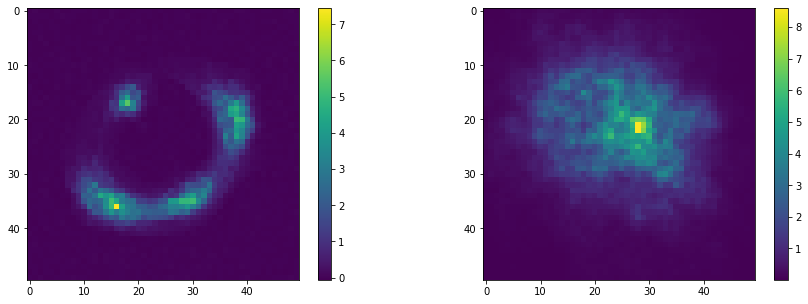

In [25]:
x0, z0 = get_fake_data(file_path = 'fake_data3.pt')

print(z0['z_lens'])
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(x0['img'])
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(z0['src'])
plt.colorbar()

In [26]:
class LensNetwork(SwyftModel):
    def __init__(self):
        super().__init__()
        self.online_z_score = swyft.networks.OnlineDictStandardizingLayer(dict(img = (50, 50)))
        self.CNN = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(10, 20, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(20, 40, 3),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(),
            torch.nn.Linear(640, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 16),
        )
        self.ptrans = swyft.networks.ParameterTransform(
            6, [(0,), (1,), (2,), (3,), (4,), (5,)], online_z_score=False
        )
        n_marginals, n_block_parameters = self.ptrans.marginal_block_shape
        n_observation_features = 16
        self.classifier = swyft.networks.MarginalClassifier(
            n_marginals,
            n_observation_features + n_block_parameters,
            hidden_features=256,
            dropout_probability = 0.1,
            num_blocks=3,
        )
        
    def forward(self, x, z):
        # Digesting x
        x = dict(img = x['img'])
        x = self.online_z_score(x)['img']
        x = self.CNN(x.unsqueeze(1)).squeeze(1)
        
        # Digesting z
        z = self.ptrans(z['z_lens'])
        
        # Combine!
        x, z = equalize_tensors(x, z)
        ratios = self.classifier(x, z)
        ratios = ratios.unsqueeze(-1)
        ratios = torch.cat([ratios, z], dim=-1)
        return dict(z_lens=ratios)

# Workflow

In [34]:
SMOKE_TEST = True

In [35]:
if SMOKE_TEST:
    Ntrain1, ME1, R1, Nsrc = 1000, 10, 1, 100
else:
    Ntrain1, ME1, R1, Nsrc = 5000, 100, 3, 1000

In [36]:
bounds = None
results = []
for i in range(R1):
    # Generate train data, x, z ~ p(x|z)p_b(z)
    dict_store = get_datadict(Ntrain1, bounds = None, file_path = 'data_%i_i%i.pt'%(Ntrain1, i))
    dataset = DictDataset(dict_store, hook = noise, x_keys = ['img'], z_keys=['z_lens', 'src'])
    
    # Train ratios: p(z_lens|img)/p(z_lens)
    net_lens = LensNetwork()
    trainer = SwyftTrainer(accelerator = 'gpu', gpus=1, max_epochs = 10)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=64)
    trainer.fit(net_lens, train_loader, train_loader)
    
    # Inference
    inference = trainer.infer(train_loader, condition_x = x0)
    bounds = get_1d_rect_bounds(inference)
    
    results.append(dict(dataset=dataset, trainer=trainer, tl = train_loader, bounds = bounds, inference=inference))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                         | Params
----------------------------------------------------------------
0 | online_z_score | OnlineDictStandardizingLayer | 0     
1 | CNN            | Sequential                   | 93.3 K
2 | ptrans         | ParameterTransform           | 0     
3 | classifier     | MarginalClassifier           | 2.4 M 
----------------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
10.038    Total estimated model params size (MB)
/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /home/weniger/codes/swyft_papergui/notebooks/GUI paper/lightning_logs/version_8757722/checkpoints exists and is not empty.
  rank_zero_warn(f"Ch

Validation sanity check: 0it [00:00, ?it/s]

/home/weniger/miniconda3/envs/p38/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Restoring states from the checkpoint path at /home/weniger/codes/swyft_papergui/notebooks/GUI paper/lightning_logs/version_8757722/checkpoints/epoch=9-step=159.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/weniger/codes/swyft_papergui/notebooks/GUI paper/lightning_logs/version_8757722/checkpoints/epoch=9-step=159.ckpt


Predicting: 16it [00:00, ?it/s]

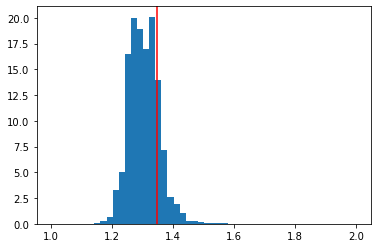

In [37]:
i = 4
#inference = trainer.infer(train_loader, condition_x = x0)
inference = results[-1]['inference']
z = inference['z_lens']
w = z[:,i,0].detach().cpu().numpy()
p = z[:,i,1].detach().cpu().numpy()
plt.axvline(z0['z_lens'][i].cpu(), color='r')
w = np.exp(w-w.max())
plt.hist(p, weights = w, bins = 50);